# Mouting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install tensorflow

In [5]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=2eb988c9d2084c92c6b66d2d53bac2e7eb57903a9cb15135b5e245e867bc73bd
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input, Flatten, MaxPooling1D, SpatialDropout1D, Activation

from keras.callbacks import EarlyStopping

from numpy import array
from sklearn.metrics import classification_report

import gensim
from gensim import models
from gensim.models import Word2Vec
import fasttext.util
import pandas as pd
import numpy as np

# Loading dataset

In [8]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/train.csv")
val_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/dev.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/test.csv")

In [9]:
print(f'train: {train_dataset.shape}\nval: {val_dataset.shape}\ntest: {test_dataset.shape}')

train: (2700, 2)
val: (1330, 2)
test: (2016, 2)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Function to plot a pie chart for a DataFrame's value counts
def plot_pie_chart(data, title):
    counts = data.value_counts()
    labels = counts.index
    sizes = counts.values

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()



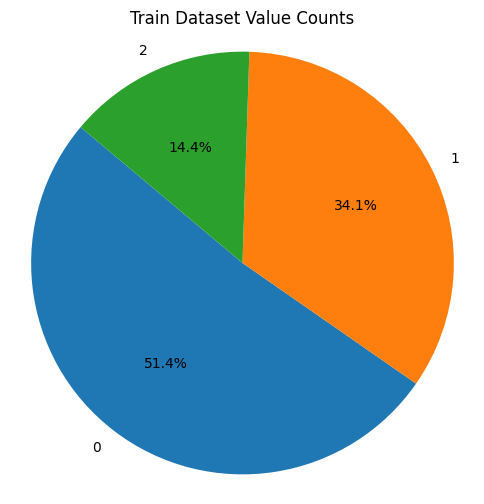

In [20]:
# Plot pie charts for each dataset
plot_pie_chart(train_dataset['label'], title="Train Dataset Value Counts")


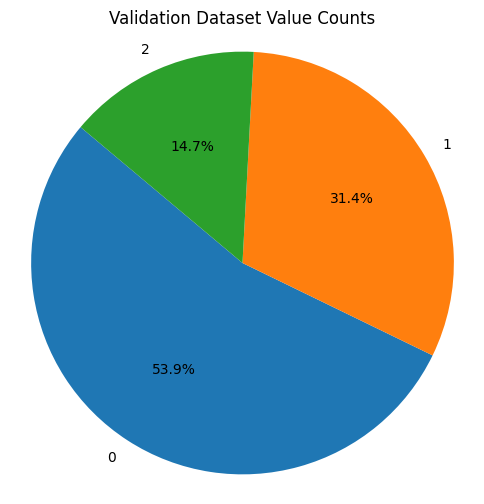

In [21]:

plot_pie_chart(val_dataset['label'], title="Validation Dataset Value Counts")

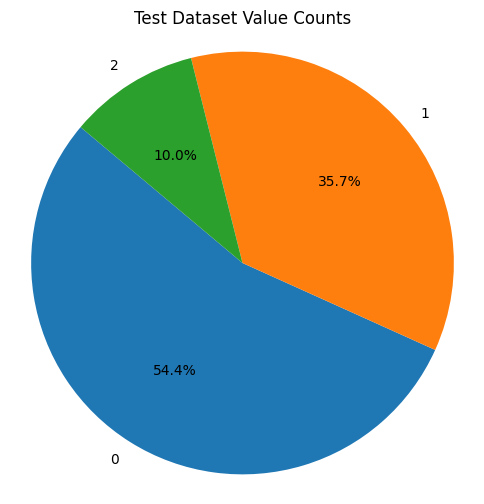

In [22]:

plot_pie_chart(test_dataset['label'], title="Test Dataset Value Counts")

In [ ]:
train_dataset['label'].value_counts()

0    1389
1     922
2     389
Name: label, dtype: int64

In [ ]:
train_x = train_dataset['text']
train_y = train_dataset['label']

val_x = val_dataset['text']
val_y = val_dataset['label']

test_x = test_dataset['text']
test_y = test_dataset['label']

# Embedding Setup

In [ ]:
tokenizer=Tokenizer(oov_token = "<OOV>", split=' ') # Splitting text based on whitespace and adding "Out of vocabulary"
tokenizer.fit_on_texts(train_x) # Using the tokenizer on out train dataset to tokenize the train dataset
train_encoded=tokenizer.texts_to_sequences(train_x)
# print(train_encoded)

In [ ]:
train_padded= pad_sequences(train_encoded, padding='post', maxlen=256)
# print(train_padded)

In [ ]:
train_padded.shape[1]

256

In [ ]:
# padding df_test
test_encoded=tokenizer.texts_to_sequences(test_x)
test_padded= pad_sequences(test_encoded, padding='post', maxlen=train_padded.shape[1])

In [ ]:
# padding df_validation
val_encoded=tokenizer.texts_to_sequences(val_x)
val_padded= pad_sequences(val_encoded, padding='post', maxlen=train_padded.shape[1])

# Loading FastText

In [ ]:
import fasttext
import numpy as np

# Load the FastText model
fasttext_model = fasttext.load_model("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/fasttext/model_bn_300.bin")

# Function that takes word vector as input and returns an embedding matrix
def embedding_creation(EMBEDDING_DIM, word_vectors, tokenizer):
    vocabulary_size = len(tokenizer.word_index) + 1
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

    for word, i in word_index.items():
        try:
            embedding_vector = word_vectors.get_word_vector(word)
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)

    return embedding_matrix

EMBEDDING_DIM = 300

# Replace 'tokenizer' with the tokenizer object you have previously created
# Assuming 'tokenizer' is defined earlier in your code

embedding_matrix = embedding_creation(EMBEDDING_DIM, fasttext_model, tokenizer)


# Model Configuration

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Initialize and train the Logistic Regression classifier with FastText embeddings
logistic_regression_classifier = LogisticRegression(max_iter=1000)

# Flatten the embedding matrix to convert it into feature vectors
train_features = [np.mean([embedding_matrix[word_index] for word_index in sentence], axis=0) for sentence in train_encoded]
train_features = np.array(train_features)

# Train the classifier
logistic_regression_classifier.fit(train_features, train_y)

# Make predictions on the validation set
val_features = [np.mean([embedding_matrix[word_index] for word_index in sentence], axis=0) for sentence in val_encoded]
val_features = np.array(val_features)
val_predictions = logistic_regression_classifier.predict(val_features)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(val_y, val_predictions)
val_classification_report = classification_report(val_y, val_predictions)

print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", val_classification_report)

# Make predictions on the test set
test_features = [np.mean([embedding_matrix[word_index] for word_index in sentence], axis=0) for sentence in test_encoded]
test_features = np.array(test_features)
test_predictions = logistic_regression_classifier.predict(test_features)

# Evaluate the model on the test set
test_accuracy = accuracy_score(test_y, test_predictions)
test_classification_report = classification_report(test_y, test_predictions)

print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:\n", test_classification_report)


Validation Accuracy: 0.706766917293233
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.78       717
           1       0.71      0.56      0.63       417
           2       0.69      0.38      0.49       196

    accuracy                           0.71      1330
   macro avg       0.70      0.61      0.63      1330
weighted avg       0.71      0.71      0.69      1330

Test Accuracy: 0.7028769841269841
Test Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.90      0.79      1096
           1       0.77      0.46      0.58       719
           2       0.58      0.49      0.53       201

    accuracy                           0.70      2016
   macro avg       0.68      0.62      0.63      2016
weighted avg       0.71      0.70      0.69      2016



In [ ]:
!pip install joblib

In [ ]:
import joblib
import os

# Save the trained model
model_filename = 'logistic_regression_model.pkl'
# Define the directory where you want to save the model
save_directory = "/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/"

# Combine the directory and filename to create the full file path
model_path = os.path.join(save_directory, model_filename)

joblib.dump(logistic_regression_classifier, model_path)

print(f"Model saved as {model_path}")

Model saved as /content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/logistic_regression_model.pkl


# Loading and testing

In [ ]:
import joblib
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the directory and filename where the model is saved
model_directory = "/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/"
model_filename = 'logistic_regression_model.pkl'

# Load the trained logistic regression model
model_path = os.path.join(model_directory, model_filename)
logistic_regression_classifier2 = joblib.load(model_path)

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

test_predictions = logistic_regression_classifier2.predict(test_features)

# Evaluate the model on the test set
test_accuracy = accuracy_score(test_y, test_predictions)
test_classification_report = classification_report(test_y, test_predictions, target_names=['0', '1', '2'], output_dict=True)

# Convert the classification report dictionary to a DataFrame
report_df = pd.DataFrame.from_dict(test_classification_report).T

# Format the DataFrame to display percentages
report_df['support'] = report_df['support'].astype(int)
report_df['accuracy'] = test_accuracy
report_df['accuracy'] = report_df['accuracy'].apply(lambda x: f'{x * 100:.2f}%')
report_df.iloc[:-1, :-1] = (report_df.iloc[:-1, :-1] * 100).applymap(lambda x: f'{x:.2f}%')

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Test Classification Report:\n", report_df)


Test Accuracy: 70.29%
Test Classification Report:
              precision    recall  f1-score     support accuracy
0               69.78%    89.96%    78.60%  109600.00%   70.29%
1               77.03%    46.18%    57.74%   71900.00%   70.29%
2               57.56%    49.25%    53.08%   20100.00%   70.29%
accuracy        70.29%    70.29%    70.29%       0.00%   70.29%
macro avg       68.12%    61.80%    63.14%  201600.00%   70.29%
weighted avg  0.711475  0.702877  0.686143        2016   70.29%
